In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
from functools import partial

import cv2
import sys
import numpy as np
import torch

sys.path.insert(0, '..')
from isegm.utils import vis, exp

from isegm.inference import utils
from isegm.inference.evaluation import evaluate_dataset, evaluate_sample

device = torch.device('cuda:0')
cfg = exp.load_config_file('../config.yml', return_edict=True)

### Init dataset

In [2]:
# Possible choices: 'GrabCut', 'Berkeley', 'DAVIS', 'COCO_MVal', 'SBD'
DATASET = 'GrabCut'
dataset = utils.get_dataset(DATASET, cfg)

### Init model

In [3]:
from isegm.inference.predictors import get_predictor

EVAL_MAX_CLICKS = 20
MODEL_THRESH = 0.49

checkpoint_path = utils.find_checkpoint(cfg.INTERACTIVE_MODELS_PATH, 'resnet34_dh128_sbd')
model = utils.load_is_model(checkpoint_path, device)

# # Possible choices: 'NoBRS', 'f-BRS-A', 'f-BRS-B', 'f-BRS-C', 'RGB-BRS', 'DistMap-BRS'
brs_mode = 'f-BRS-B'
predictor = get_predictor(model, brs_mode, device, prob_thresh=MODEL_THRESH)

### Dataset evaluation

In [4]:
TARGET_IOU = 0.9

all_ious, elapsed_time = evaluate_dataset(dataset, predictor, pred_thr=MODEL_THRESH, 
                                          max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)
mean_spc, mean_spi = utils.get_time_metrics(all_ious, elapsed_time)
noc_list, over_max_list = utils.compute_noc_metric(all_ious,
                                                   iou_thrs=[0.8, 0.85, 0.9],
                                                   max_clicks=EVAL_MAX_CLICKS)

header, table_row = utils.get_results_table(noc_list, over_max_list, brs_mode, DATASET,
                                            mean_spc, elapsed_time, EVAL_MAX_CLICKS)
print(header)
print(table_row)

-----------------------------------------------------------------------------------------------
|  BRS Type   |  Dataset  | NoC@80% | NoC@85% | NoC@90% |>=20@85% |>=20@90% | SPC,s |  Time   |
-----------------------------------------------------------------------------------------------
|   f-BRS-B   |  GrabCut  |  1.78   |  2.06   |  2.52   |    1    |    1    | 0.082 | 0:00:10 |


### Single sample eval

[0.7923468  0.8854471  0.89824456 0.92122626 0.93558127 0.9379461
 0.9418884  0.9110682  0.92096454 0.9260774  0.93037474 0.93439186
 0.9307009  0.93656826 0.939067   0.94287443 0.9434171  0.94514424
 0.9507299 ]


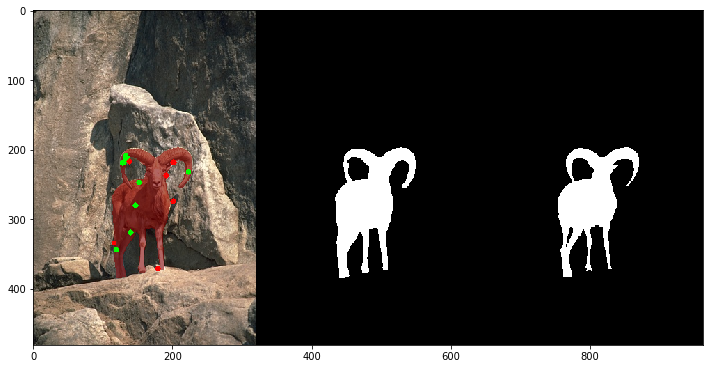

In [5]:
sample_id = 12
TARGET_IOU = 0.95

sample = dataset.get_sample(sample_id)
gt_mask = sample['instances_mask']
image = dataset[sample_id]['images']

clicks_list, ious_arr, pred = evaluate_sample(image, gt_mask, predictor,
                                              pred_thr=MODEL_THRESH,
                                              max_iou_thr=TARGET_IOU, max_clicks=EVAL_MAX_CLICKS)

pred_mask = pred > MODEL_THRESH
draw = vis.draw_with_blend_and_clicks(sample['image'], mask=pred_mask, clicks_list=clicks_list)
draw = np.concatenate((draw,
    255 * pred_mask[:, :, np.newaxis].repeat(3, axis=2),
    255 * (gt_mask > 0)[:, :, np.newaxis].repeat(3, axis=2)
), axis=1)

print(ious_arr)

plt.figure(figsize=(12, 16))
plt.imshow(draw)
plt.show()